In [1]:
from __future__ import print_function
import argparse
import torch
print(torch.__version__)
import torch.nn as NN
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

1.7.1


In [2]:
# Define the model #CNN Model
class Net(NN.Module):
    def __init__(self):
        super(Net, self).__init__() #initialize the superclass
         #2 convolutionaal layers
        self.conv1 = NN.Conv2d(1, 20, 5, stride=1) #1 layer
        self.conv2 = NN.Conv2d(20, 50, 5, stride=1) #output of first layer will be input to next layer, 20 convolutional layers and the output will be 50 conv layers
        #20 and 50 are 'hyperparameters' and these are somewhat arbitrary based on performance
        self.pool = NN.MaxPool2d(2, 2)
        self.fc1 = NN.Linear(4*4*50, 20) #fully connected network, output will be 20 dimensions
        self.fc2 = NN.Linear(20, 10)

    def forward(self, x): #the whole pipeline of the computation
        x = self.pool( F.relu(self.conv1(x)) ) #run through the first conv layers then apply the activation function
        #ReLU takes input, anything below zero it returns zero
        #No padding here, pooling reduces size of images by half
        x = self.pool( F.relu(self.conv2(x)) ) #apply second conv layer with relu and pooling
        x = x.view(-1, 4*4*50) #flattens the image
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
        
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() #for each new data make a new gradient
        #output = model(torch.autograd.Variable(data))
        output = model( data )
        loss = F.nll_loss(output, target) #gets the error between the model output and the ground truth
        #.nll_loss is an error function
        loss.backward() #backpropogate the gradient
        optimizer.step() #update the parameters 
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_loader): #test the model on the test dataset
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [3]:
train_batchsize = 64
test_batchsize = 1000
trainEpochs = 10
learningRate = 0.01
sgdmomentum = 0.9
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
#tranform converts input into tensoors aand then normalize it

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batchsize, shuffle=True)

testset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize, shuffle=False)

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw
Processing...




C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
# Check samples I
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

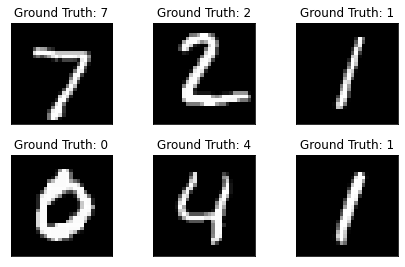

In [5]:
# Check samples II
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].numpy(), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [6]:
# Train and test
model = Net()
optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum = sgdmomentum) #Stochastic Gradient Search

#epoch is a minibatch of data
for epoch in range(trainEpochs):
    train(model, trainloader, optimizer, epoch)
    test(model, testloader)


C:\ProgramData\Anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.284337
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.343673
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.366328
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.109828
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.110291
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.049436
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.141679
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.062940
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.043758
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.132893

Test set: Average loss: 0.0492, Accuracy: 9853/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.093009
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.058254
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.092242
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.071805
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.057262
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.065759
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.040552
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.082740
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.037248
T

In [ ]:
torch.save(model.state_dict(),"mnist_cnn.pt")